# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint


The objective of this experiment:

- ** FEATURE EXTRACTION**
    - extract eigenvalues and eigenvectors, and choose the best N principal components as features
    - use deep features


- ** MODEL SELECTION**:

    -  Use kNN classifier with PCA features, and find validation accuracy
    -  Use kNN classifier with Deep features, and find validation accuracy
    

- ** PREDICTION**: use the  model to predict labels on test data, and see how well the validation accuracy estimated the test accuracy.


- ** COMPARISON OF ALL ACCURACIES**: compare training, validation and testing accuracies.

Let us go through these step-by-step.

In previous session notebook, we understood the data, and split it into train, val, and test. We then manipulated it so that the data is of uniform size, normalized, and mean subtracted. (Not that these operations can be performed on any data, not just images.)

We then saved the final datasets as "data.npz" file. Let us load them:

#### Setup Steps

In [0]:
#@title Please enter your registration id to start: (e.g. P181900101) { run: "auto", display-mode: "form" }
Id = "P19A06E_test" #@param {type:"string"}


In [0]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "981234567" #@param {type:"string"}


In [0]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()
  
notebook="BLR_M1W4_SAT_EXP_1" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
#    ipython.magic("sx apt-get update")
    ipython.magic("sx apt-get -y install python-opencv")
    ipython.magic("sx pip3 install opencv-python")
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/week3/Exp2/AIML_DS_VGG-FACE-INDIAN_STD.zip")
    ipython.magic("sx unzip AIML_DS_VGG-FACE-INDIAN_STD.zip")
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/week3/Exp2/VGG_Utils.py")
   # ipython.magic("sx mv VGG_Utils.py?dl=1 VGG_Utils.py")
    print ("Setup completed successfully")
    return

def submit_notebook():
    
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getComplexity() and getAdditional() and getConcepts():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "id" : Id, "file_hash" : file_hash, "notebook" : notebook}

      r = requests.post(url, data = data)
      print("Your submission is successful. Ref:", submission_id)
      return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if Additional: return Additional      
    else: raise NameError('')
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
  
else:
  print ("Please complete Id and Password cells before running setup")



Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  adwaita-icon-theme at-spi2-core dconf-gsettings-backend dconf-service
  fontconfig gdal-data glib-networking glib-networking-common
  glib-networking-services gsettings-desktop-schemas gtk-update-icon-cache
  hicolor-icon-theme humanity-icon-theme i965-va-driver ibverbs-providers
  libaacs0 libarmadillo8 libarpack2 libatk-bridge2.0-0 libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libavcodec57 libavformat57 libavutil55 libbdplus0
  libbluray2 libcairo-gobject2 libcairo2 libcharls1 libchromaprint1 libcolord2
  libcroco3 libcrystalhd3 libcups2 libdap25 libdapclient6v5 libdatrie1
  libdc1394-22 libdconf1 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libepoxy0 libepsilon1 libexif12 libfabric1 libfreexl1
  libfyba0 libgd3 libgdal20 libgdcm2.8 libgdk-pixbuf2.0-0 libgdk-pixbuf2

In [0]:
import matplotlib.pyplot as plt
import numpy as np

from VGG_Utils import *

In [0]:
# Loading data
data = np.load("AIML_DS_VGG-FACE-INDIAN_STD/data_backup.npz")

# Getting train, val and test data and labels, and the mean_image
data_train = data["data_train"]
labels_train = data["labels_train"]
data_val = data["data_val"]
labels_val = data["labels_val"]
data_test = data["data_test"]
labels_test = data["labels_test"]
mean_image = data["mean_image"]

**Exercise 1: Plot the first 50 training images. You can use _matplotlib_ or any library of your choice.**

In [0]:
# Plot the first 50 images
# Your code here


# 1. FEATURE EXTRACTION

For the given problem, we would be using **two** types of features - PCA, and Deep Features.

After this exercise, we will compare the results using the two different types of features on the validation set. We shall then fix the final model based on which feature set performs better according to an evaluation metric.

# 1.1. First $N$ Principal Components with maximum eigenvalues

As we have learnt in the lecture, PCA finds the set of orthonormal vectors which best
describe the distribution of the underlying dataset. In the given dataset, we have $n$
images of size $K \times K$. (We know that $K = 224$, and $n = 120$ in the training set)

We have already seen how PCA features are extracted, let us recap them:

## 1.1.1. Find eigenvalues and eigenvectors

In [0]:
def find_eigenvalues_and_eigenvectors_simply(A):
    # Your code here
    L = 1 / len(A.T) * np.dot(A, A.T)
    e, u = np.linalg.eig(L)
    w = e
    v = np.dot(A.T, u)
    return w, v

In [0]:
eigenvalues, eigenvectors = find_eigenvalues_and_eigenvectors_simply(data_train)

## 1.1.2. Reordering, normalizing

But, since we found the eigenvalues and eigenvectors in a roundabout way, we need to:
- reorder them so that they are in descending order of eigenvalues,
- normalize the eigenvectors so that their norms are 1.

In [0]:
# REORDER

# Find the required order of indices to sort  eigenvalues in decreasing order
sort_index = np.argsort(eigenvalues)[::-1]

# Use the calculated order of indices to reorder eigenvalues and eigenvectors
eigenvalues = eigenvalues[sort_index]
eigenvectors = eigenvectors[:, sort_index]

In [0]:
# NORMALIZE
eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=0)

## 1.1.3. Eigenfaces

The eigenvectors thus found are called eigenfaces (because we found the eigenvectors of faces...).

Since an eigenvector is of dimension ($K^2$,), it can be reshaped to $(K, K)$ and displayed as an image!

**Exercise 2: Display the first 50 eigenfaces.** Hint: we solved a similar problem in Exercise 6.

In [0]:
# Plot the first 50 eigenfaces
# Your code here


## 1.1.4. Computing good value for $N$

_(already seen in previous lab)_

In the given dataset, there are as many eigenvectors as the number of training examples. This can be verified by:

In [0]:
eigenvectors.shape

(50176, 120)

Since each column is an eigenvector, there are 120 eigenvectors, each of 50176 dimensions. But usually, a smaller number $N$ of eigenvectors is chosen as a basis to make feature vectors.

To decide the on the number $N$, i.e. the number of most important eigenvectors to keep as the basis, the cumulative sum of eigenvalues (assuming they are in decreasing order) divided by the total sum of eigenvalues, vs. the number of eigenvalues considered ($M$) is plotted.

This plot shall show the fraction of total variance retained ($r$) vs. the number of eigenvalues considered ($M$). This way, the plot gives a good understanding of the point of diminishing returns, i.e. the point where little variance is retained by retaining additional eigenvalues.

This can be understood by the following equation:

$$r = \frac{\sum_{k=1}^{M}\lambda_k}{\sum_{k=1}^{n}\lambda_k},\ \ \ \  M <= n$$

Plotting $r$ vs $M$ shall give a good idea of the impact of varying $M$ on $r$.

Let's say we want to retain only 80% of the variance involved. Then we should look for the minimum value of $M$ for which $r > 0.8$.

**Plot $r$ vs $M$:**

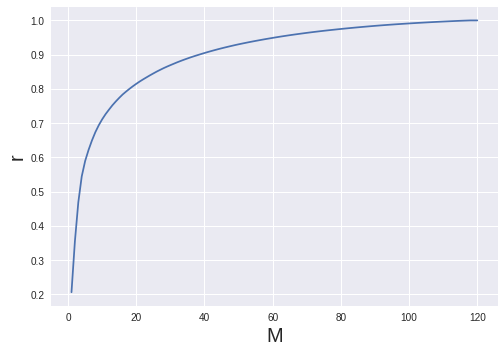

In [0]:
# Plot r vs M

# Values of M to consider: 1, 2,..., n
M = np.array(range(1, len(data_train) + 1))

# Calculate r for all values of M
r = np.cumsum(eigenvalues)/np.sum(eigenvalues)

# Plot r vs M
plt.plot(M, r)
plt.xlabel("M", fontsize=20)
plt.ylabel("r", fontsize=20)
plt.grid("on")
plt.show()

We can see from the plot that an $M$ value of around 20 gives an $r$ value of 0.8.

So let us choose $N = 20$.

In [0]:
N = 20

That means we only choose $N$ **principal components**. In other words, we choose those $N$ types of information that are most important in faces. We can look at the plots of the eigenfaces to see what sort of information we are choosing.

Let us note the first N principal components, i.e. the first N eigenvectors:

In [0]:
pca_vectors = eigenvectors[:, :N]

## 1.1.5. Finding features using first $N$ Principal Components

_(already seen in previous lab)_

Since we are using the most important eigenfaces as the _basis_ vectors, we need to project the data into these basis components to find the relevant features. We do this by finding the dot product of the data maxtrix and the matrix of the most important eigenvectors.

We know that the data (`data_train`, `data_val`, `data_test`) is of shape $n \times K^2$. We also know that the `pca_vectors` matrix is of shape $K^2 \times N$.

In [0]:
pca_features_train = np.dot(data_train, pca_vectors)
pca_features_val = np.dot(data_val, pca_vectors)
pca_features_test = np.dot(data_test, pca_vectors)

Let's check the shapes of the features:

In [0]:
print(pca_features_train.shape, pca_features_val.shape, pca_features_test.shape)

(120, 20) (40, 20) (40, 20)


Hence, we can see that we have transformed our data from $n \times K^2$ to $n \times N$.

# 1.2. Deep features

We used a deep neural network to transform the images into 2622 good features. Let us read these features: 

In [0]:
# Deep features
deep_features = np.load("AIML_DS_VGG-FACE-INDIAN_STD/vgg_face_deep_features.npz")
deep_features_train = deep_features["train"]
deep_features_val = deep_features["val"]
deep_features_test = deep_features["test"]

In [0]:
print(deep_features_train.shape, deep_features_val.shape, deep_features_test.shape)

(120, 2622) (40, 2622) (40, 2622)


# 2. Training and Prediction

Till now, we have gotten familiar with kNN algorithm and linear classifier. We have PCA features and Deep features at our disposal.

Let us now train the model on the training set, and compare accuracies on the test set to see which model performs better using which feature:

- 1) kNN classifier on PCA features,
- 2) kNN classifier on Deep features,


## Function to choose algorithm, features and labels to get accuracy

We created a convenient function to which you can choose the algorithm you want to use - `'kNN'`, `'NB'` (Naive Bayes), or `'linear'` (multiclass linear classifier) - and input features and labels for training and testing:

**`acc = predict_and_find_accuracy(algorithm, train_features, train_labels, given_features, given_labels, k)`**

INPUTS:

- **`algorithm`** is one of `'kNN'`


- **`train_features`** are either `pca_features_train` or `deep_features_train`,


- **`train_labels`** are `labels_train`,


- **`given_features`** are `XXX_features_val` in case of validation, and `XXX_features_test` in case of testing (`XXX` being either `pca` or `deep` depending on what you chose to train the model on)


- **`given_labels`** are `labels_val` in case of validation, and `labels_test` in case of testing.


- **`k`** is the value of $k$ to be used _in case_ we are using kNN classifier.

OUTPUT:

- **acc** is the accuracy of the `algorithm` on `given_features` & `given_labels` after being trained on `train_features` & `train_labels`.

# 1 k Nearest Neighbours

By now, we are quite familiar with the kNN algorithm.

But how to find the best value of $k$? We will use the validation set to determine this.

## Find best $k$ for PCA features and Test accuracy

**Exercise 3:** Using the convenient function, find the validation accuracies of a kNN classifier on pca_features using different values of $k$. Then, choose that $k$ which gives the best validation accuracy. Finally, use this $k$ to get the test accuracy.

We shall choose a $k$ among {1, 3, 5, 7, 9, 11}.

In [0]:
values_of_k = [1, 3, 5, 7, 9, 11]

In [0]:
# Your code here
????????
best_pca_k = ???????
print(best_pca_k)
kNN_pca_test_acc = ????????
print(kNN_pca_test_acc)

The best $k$ for PCA should be 1.

---- **(If not, please recheck your code)**

## Find best $k$ for Deep features and Test accuracy

**Exercise 4:** Using the convenient function, find the validation accuracies of a kNN classifier on deep_features using different values of $k$. Then, choose that $k$ which gives the best validation accuracy. Finally, use this $k$ to get the test accuracy.

We shall choose a $k$ among {1, 3, 5, 7, 9, 11}.

In [0]:
# Your code here
????????
best_deep_k = ???????
print(best_deep_k)
kNN_deep_test_acc = ????????
print(kNN_deep_test_acc)

The best $k$ for deep features should be 1.

---- **(If not, please recheck your code)**

We can observe that in most cases, training accuracies are quite high, while validation and testing accuracies are not. Thus, a much better estimate of the test accuracy is the validation accuracy, rather than the training accuracy.

### Low accuracies:

As can be seen, the values of the validation accuracies do not go above 0.625, with PCA giving better accuracy than deep features. This is much better than the accuracy of a random guess (0.1), but it is quite less on an absolute level.

**Reason:** We used **ONLY** 12 training images per class. That is not nearly enough to train any machine learning model!

Machine learning models, especially deep models, always perform better with more data. This is why we have seen "Big Data" become popular - we now have access to large amounts of data, which is making all the machine learning models better than ever before.

So, in real cases where we don't have a test set, we make a small validation data and find validation accuracy to choose our model. From the validation accuracies, we find that the **Linear Classifier** and **Naive Bayes Classifier** using **principal eigenfaces** perform better than the other models which hold for test accuracies too.

# CONCLUSION

Through the above exercises, we learnt about the fundamental parts of a Machine Learning system. Apart from learning the importance of validation set, we revised a few concepts we have gone through in past few lectures such as PCA, kNN, and evaluation metrics.

### Please answer the questions below to complete the experiment:




In [0]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging me" #@param ["Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging me", "Was Tough, but I did it", "Too Difficult for me"]


In [0]:
#@title If it was very easy, what more you would have liked to have been added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "test" #@param {type:"string"}

In [0]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["Yes", "No"]

In [0]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id =return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful. Ref: 2804
